In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

! cp -r "/content/gdrive/My Drive/InfoFaceRecognize/dataset/images/" .
! cp "/content/gdrive/My Drive/InfoFaceRecognize/weights/last_model_mnv2.h5" .
! unzip mydataset.zip

Mounted at /content/gdrive
unzip:  cannot find or open mydataset.zip, mydataset.zip.zip or mydataset.zip.ZIP.


In [ ]:
!pip install mediapipe

### Import Libs ###

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import mediapipe as mp
import pandas as pd
import numpy as np
import random
import cv2

### Set Params ###

In [151]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

race_label = {
    0: 'Black',
    1: 'East Asian',
    2: 'Indian',
    3: 'Latino_Hispanic',
    4: 'Middle Eastern',
    5: 'Southeast Asian',
    6: 'White'
 }

gender_label = {0: 'Female', 1: 'Male'}

age_label = {
    0: '0-2',
    1: '10-19',
    2: '20-29',
    3: '3-9',
    4: '30-39',
    5: '40-49',
    6: '50-59',
    7: '60-69',
    8: 'more than 70'
 }

age_weights = [4.45811712,  1.00083209,  0.37950401,  0.80876815,  0.52459874, 
                0.95672924,  1.62408858,  3.86007702, 12.68776371]

### Functions ###

In [84]:
mp_face_mesh = mp.solutions.face_mesh

def get_face(image):

    h, w = image.shape[:2]
    detected_face = None

    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1,
        min_detection_confidence=0.3, min_tracking_confidence=0.3) as face_mesh:
        
        # Recognize face in a image
        results = face_mesh.process(image)

        # To improve performance
        image.flags.writeable = True

        # Iterate over found faces
        if results.multi_face_landmarks:
            annotated_image = image.copy()
            for face_landmarks in results.multi_face_landmarks:
                h, w, c = image.shape
                cx_min=  w
                cy_min = h
                cx_max= cy_max= 0

                for id, lm in enumerate(face_landmarks.landmark):
                    cx, cy = int(lm.x * w), int(lm.y * h)
                    if cx < cx_min:
                        cx_min = cx if cx >= 0 else 0
                    if cy < cy_min:
                        cy_min = cy if cy >= 0 else 0
                    if cx > cx_max:
                        cx_max = cx if cx >= 0 else 0
                    if cy > cy_max:
                        cy_max = cy if cy >= 0 else 0
                                
                detected_face = annotated_image[int(cy_min):int(cy_max), 
                                                int(cx_min):int(cx_max)]

    return detected_face

### Load model ###

In [85]:
face_model = load_model('last_model_mnv2.h5')

### Load and transform data ###

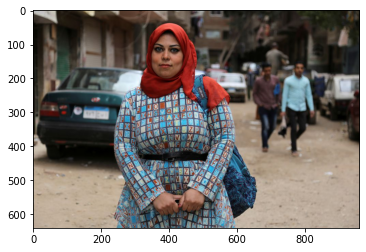

In [211]:
img = cv2.imread('images/img_3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

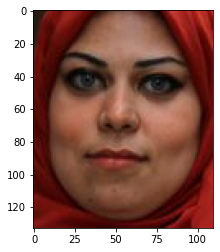

In [212]:
face = get_face(img)
plt.imshow(face);

### Transform image to inference ###

In [213]:
img_pred = cv2.resize(face, (IMAGE_WIDTH, IMAGE_HEIGHT), 
                      interpolation=cv2.INTER_CUBIC)
img_pred = np.expand_dims(img_pred, axis=0)
img_pred = img_pred/ 255.
img_pred.shape

(1, 224, 224, 3)

### Predict ###

In [214]:
prediction = face_model.predict(img_pred)
prediction

[array([[1.8028369e-06, 1.9836505e-06, 4.2300466e-03, 1.0135323e-03,
         9.9398285e-01, 6.0713623e-04, 1.6254287e-04]], dtype=float32),
 array([[9.9999976e-01, 2.9231407e-07]], dtype=float32),
 array([[2.8656265e-08, 7.8428449e-04, 2.1626242e-02, 3.4003637e-07,
         3.9382726e-01, 5.1888889e-01, 6.3647524e-02, 1.2248037e-03,
         6.2762865e-07]], dtype=float32)]

In [215]:
print(f"""
    Race: {race_label[np.argmax(prediction[0])]}
    Gender: {gender_label[np.argmax(prediction[1])]}
    Age: {age_label[np.argmax(prediction[2] * age_weights)]}
""")


    Race: Middle Eastern
    Gender: Female
    Age: 40-49

